In [921]:
import pandas as pd
import numpy as np

import numba as nb

# Baseline

In [884]:
import time
from typing import Iterator, List, Collection, Callable

import pandas as pd
from tqdm import tqdm

# A very general type hint for a prediction function.
# A prediction function takes a triplet of (test object description, train descriptions, train labels)
# and outputs a bool prediction
PREDICTION_FUNCTION_HINT = Callable[
    [Collection, Collection[Collection], Collection[bool]], bool
]


def load_data(df_name: str) -> pd.DataFrame:
    """Generalized function to load datasets in the form of pandas.DataFrame"""
    if df_name == 'tic_tac_toe':
        return load_tic_tac_toe()

    raise ValueError(f'Unknown dataset name: {df_name}')


def load_tic_tac_toe() -> pd.DataFrame:
    """Load tic-tac-toe dataset from UCI repository"""
    column_names = [
        'top-left-square', 'top-middle-square', 'top-right-square',
        'middle-left-square', 'middle-middle-square', 'middle-right-square',
        'bottom-left-square', 'bottom-middle-square', 'bottom-right-square',
        'Class'
    ]
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data'
    df = pd.read_csv(url, names=column_names)
    df['Class'] = [x == 'positive' for x in df['Class']]
    return df


def binarize_X(X: pd.DataFrame) -> 'pd.DataFrame[bool]':
    """Scale values from X into pandas.DataFrame of binary values"""
    dummies = [pd.get_dummies(X[f], prefix=f, prefix_sep=': ') for f in X.columns]
    X_bin = pd.concat(dummies, axis=1).astype(bool)
    return X_bin


def predict_with_generators(
        x: set, X_train: List[set], Y_train: List[bool],
        min_cardinality: int = 6
) -> bool:
    """Lazy prediction for ``x`` based on training data ``X_train`` and ``Y_train``
    Parameters
    ----------
    x : set
        Description to make prediction for
    X_train: List[set]
        List of training examples
    Y_train: List[bool]
        List of labels of training examples
    min_cardinality: int
        Minimal size of an intersection required to count for counterexamples
    Returns
    -------
    prediction: bool
        Class prediction for ``x`` (either True or False)
    """
    X_pos = [x_train for x_train, y in zip(X_train, Y_train) if y]
    X_neg = [x_train for x_train, y in zip(X_train, Y_train) if not y]

    n_counters_pos = 0  # number of counter examples for positive intersections
    for x_pos in X_pos:
        intersection_pos = x & x_pos
        if len(intersection_pos) < min_cardinality:  # the intersection is too small
            continue

        for x_neg in X_neg:  # count all negative examples that contain intersection_pos
            if (intersection_pos & x_neg) == intersection_pos:
                n_counters_pos += 1

    n_counters_neg = 0  # number of counter examples for negative intersections
    for x_neg in X_neg:
        intersection_neg = x & x_neg
        if len(intersection_neg) < min_cardinality:
            continue

        for x_pos in X_pos:  # count all positive examples that contain intersection_neg
            if (intersection_neg & x_pos) == intersection_neg:
                n_counters_neg += 1

    perc_counters_pos = n_counters_pos / len(X_pos)
    perc_counters_neg = n_counters_neg / len(X_neg)

    prediction = perc_counters_pos < perc_counters_neg
    return prediction

def predict_array(
        X: List[set], Y: List[bool],
        n_train: int, update_train: bool = True, use_tqdm: bool = False,
        predict_func: PREDICTION_FUNCTION_HINT = predict_with_generators,
        min_cardinality: int = 5
) -> Iterator[bool]:
    """Predict the labels of multiple examples from ``X``
    Parameters
    ----------
    X: List[set]
        Set of train and test examples to classify represented with subsets of attributes
    Y: List[bool]
        Set of train and test labels for each example from X
    n_train: int
        Initial number of train examples. That is, make predictions only for examples from X_train[n_train:]
    update_train: bool
        A flag whether to consider true labels of predicted examples as training data or not.
        If True, then for each X_i the training data consists of X_1, X_2, ..., X_{n_train}, ...,  X_{i-1}.
        If False, then for each X_i the training data consists of X_1, X_2, ..., X_{n_train}
    use_tqdm: bool
        A flag whether to use tqdm progress bar (in case you like progress bars)
    predict_func: <see PREDICTION_FUNCTION_HINT defined in this file>
        A function to make prediction for each specific example from ``X``.
        The default prediction function is ``predict_with_generator`` (considered as baseline for the home work).
    Returns
    -------
    prediction: Iterator
        Python generator with predictions for each x in X[n_train:]
    """
    for i, x in tqdm(
        enumerate(X[n_train:]),
        initial=n_train, total=len(X),
        desc='Predicting step by step',
        disable=not use_tqdm,
    ):
        n_trains = n_train + i if update_train else n_train
        yield predict_func(x, X[:n_trains], Y[:n_trains], min_cardinality = min_cardinality)


def apply_stopwatch(iterator: Iterator):
    """Measure run time of each iteration of ``iterator``
    The function can be applied e.g. for the output of ``predict_array`` function
    """
    outputs = []
    times = []

    t_start = time.time()
    for out in iterator:
        dt = time.time() - t_start
        outputs.append(out)
        times.append(dt)
        t_start = time.time()

    return outputs, times

In [885]:
df = pd.read_csv('/content/healthcare-dataset-stroke-data (1).csv')

In [886]:
df = df[:1000]

df = df.sample(frac=1).reset_index(drop=True)

In [887]:
df['bmi'].fillna(df['bmi'].mean(), inplace=True)

In [888]:
df.drop(columns='id', inplace=True)

obj_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
num_cols = ['avg_glucose_level', 'bmi', 'age']

df = pd.concat([df, pd.get_dummies(df[obj_cols])], axis=1)
df.drop(columns=obj_cols, inplace=True)

In [889]:
def binarize_numerical(ds, num_cols):
  df = ds.copy()
  cols_new = []
  for col in num_cols:
    mean = df[col].mean()
    conditions = [
      (df[col] < mean),
      (df[col] >= mean)]

    values = [0, 1]
    
    df[f'binary_{col}'] = np.select(conditions, values)
    cols_new += [f'binary_{col}']
  df.drop(columns=num_cols, inplace=True)
  return df

def binarize_numerical_hard(ds, num_cols):
  df = ds.copy()
  cols_new = []
  for col in num_cols:
    mean = df[col].mean()
    std = df[col].std()
    conditions = [
      (df[col] < mean - 3*std) | (df[col] > mean + 3*std),
      (df[col].between(mean - 3*std, mean-2*std, inclusive=True)) | (df[col].between(mean + 2*std, mean+3*std, inclusive=True)),
      (df[col].between(mean - 2*std, mean-1*std, inclusive=True)) | (df[col].between(mean + 1*std, mean+2*std, inclusive=True)),
      (df[col].between(mean - 1*std, mean-0*std, inclusive=True)) | (df[col].between(mean + 0*std, mean+1*std, inclusive=True)),
      ]

    values = [0, 1, 2, 3]
    
    df[f'binary_{col}'] = np.select(conditions, values)
    cols_new += [f'binary_{col}']
  df.drop(columns=num_cols, inplace=True)
  return df, cols_new

In [890]:
def get_bools(ds, cols_new):
  df = ds.copy()
  df = pd.concat([df, pd.get_dummies(ds[cols_new])], axis=1)
  df.drop(columns=cols_new, inplace=True)
  df = df.astype(np.bool)
  return df

In [891]:
df = binarize_numerical(df, num_cols)

df.head()

,hypertension,heart_disease,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,...,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,binary_avg_glucose_level,binary_bmi,binary_age
0,1,1,1,0,1,0,1,0,0,1,...,0,1,0,0,0,0,1,1,1,1
1,0,0,0,1,0,1,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
2,0,0,0,1,0,0,1,0,0,1,...,0,1,0,0,1,0,0,0,1,1
3,0,0,0,1,0,1,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [892]:
#df = get_bools(df, cols)

In [893]:
df = df.astype(bool)

In [894]:
y = df['stroke']
X = df.drop(columns='stroke')

In [895]:
y = y.values.tolist()

In [896]:
X_bin = [set(X.columns[x]) for idx, x in X.iterrows()]
X_bin[0]

{'Residence_type_Rural',
 'binary_age',
 'binary_avg_glucose_level',
 'binary_bmi',
 'ever_married_Yes',
 'gender_Male',
 'heart_disease',
 'hypertension',
 'smoking_status_smokes',
 'work_type_Private'}

In [897]:
n_train=100

In [898]:
%%time
gen = predict_array(X_bin, np.array(y), n_train, use_tqdm=True, min_cardinality=1)
y_preds, t_preds = apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 1000/1000 [00:21<00:00, 41.96it/s]

CPU times: user 21.3 s, sys: 92.4 ms, total: 21.3 s
Wall time: 21.5 s


In [899]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
print(classification_report(y[n_train:], y_preds))

              precision    recall  f1-score   support

       False       0.77      0.95      0.85       681
        True       0.43      0.12      0.19       219

    accuracy                           0.75       900
   macro avg       0.60      0.54      0.52       900
weighted avg       0.69      0.75      0.69       900



# Numpy realization + JIT

In [900]:
import numba as nb

In [901]:

@nb.jit
def predict_with_generators(
        x: List[bool], X_train: List[set], Y_train: List[bool],
        min_cardinality: int = 1
) -> bool:
    """Lazy prediction for ``x`` based on training data ``X_train`` and ``Y_train``
    Parameters
    ----------
    x : set
        Description to make prediction for
    X_train: List[set]
        List of training examples
    Y_train: List[bool]
        List of labels of training examples
    min_cardinality: int
        Minimal size of an intersection required to count for counterexamples
    Returns
    -------
    prediction: bool
        Class prediction for ``x`` (either True or False)
    """

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_pos = np.array(X_train)[np.array(Y_train)==1]
    X_neg = np.array(X_train)[np.array(Y_train)==0]

    
    n_counters_pos = 0  # number of counter examples for positive intersections
    for x_pos in X_pos:
        intersection_pos = (x & x_pos)
        if (intersection_pos).sum() < min_cardinality:  # the intersection is too small
            continue

        n_counters_pos = X_neg[np.where(np.all(X_neg == intersection_pos, axis=1))].shape[0]

    n_counters_neg = 0  # number of counter examples for negative intersections
    for x_neg in X_neg:
        intersection_neg = (x & x_neg)
        if (intersection_neg).sum() < min_cardinality:
            continue

        n_counters_neg = X_pos[np.where(np.all(X_pos == intersection_neg, axis=1))].shape[0]

    perc_counters_pos = n_counters_pos / X_pos.shape[0]
    perc_counters_neg = n_counters_neg / X_neg.shape[0]
    prediction = perc_counters_pos < perc_counters_neg
    return prediction # lets return probability 

def predict_array(
        X: List[set], Y: List[bool],
        n_train: int, update_train: bool = True, use_tqdm: bool = False,
        predict_func: PREDICTION_FUNCTION_HINT = predict_with_generators,
        min_cardinality: int = 5
) -> Iterator[bool]:
    """Predict the labels of multiple examples from ``X``
    Parameters
    ----------
    X: List[set]
        Set of train and test examples to classify represented with subsets of attributes
    Y: List[bool]
        Set of train and test labels for each example from X
    n_train: int
        Initial number of train examples. That is, make predictions only for examples from X_train[n_train:]
    update_train: bool
        A flag whether to consider true labels of predicted examples as training data or not.
        If True, then for each X_i the training data consists of X_1, X_2, ..., X_{n_train}, ...,  X_{i-1}.
        If False, then for each X_i the training data consists of X_1, X_2, ..., X_{n_train}
    use_tqdm: bool
        A flag whether to use tqdm progress bar (in case you like progress bars)
    predict_func: <see PREDICTION_FUNCTION_HINT defined in this file>
        A function to make prediction for each specific example from ``X``.
        The default prediction function is ``predict_with_generator`` (considered as baseline for the home work).
    Returns
    -------
    prediction: Iterator
        Python generator with predictions for each x in X[n_train:]
    """
    for i, x in tqdm(
        enumerate(X[n_train:]),
        initial=n_train, total=len(X),
        desc='Predicting step by step',
        disable=not use_tqdm,
    ):
        n_trains = n_train + i if update_train else n_train
        yield predict_func(x, np.array(X[:n_trains]), np.array(Y[:n_trains]), min_cardinality = min_cardinality)


def apply_stopwatch(iterator: Iterator):
    """Measure run time of each iteration of ``iterator``
    The function can be applied e.g. for the output of ``predict_array`` function
    """
    outputs = []
    times = []

    t_start = time.time()
    for out in iterator:
        dt = time.time() - t_start
        outputs.append(out)
        times.append(dt)
        t_start = time.time()

    return outputs, times

In [902]:
n_train = 100

In [905]:
%%time
gen = predict_array(np.array(X), np.array(y), n_train, use_tqdm=True, min_cardinality=3)
y_preds, t_preds = apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 1000/1000 [00:08<00:00, 105.29it/s]

CPU times: user 8.48 s, sys: 40.9 ms, total: 8.52 s
Wall time: 8.56 s


In [906]:
%%time
gen = predict_array(np.array(X), np.array(y), n_train, use_tqdm=True, min_cardinality=3, update_train=False)
y_preds_fixedtrain, t_preds_fixedtrain = apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 1000/1000 [00:00<00:00, 909.18it/s]

CPU times: user 972 ms, sys: 11 ms, total: 983 ms
Wall time: 999 ms


In [907]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
print(classification_report(y[n_train:], y_preds))

              precision    recall  f1-score   support

       False       0.76      0.99      0.86       681
        True       0.12      0.00      0.01       219

    accuracy                           0.75       900
   macro avg       0.44      0.50      0.43       900
weighted avg       0.60      0.75      0.65       900



In [908]:
y_test = y[n_train:]

In [909]:
from sklearn.metrics import accuracy_score, f1_score

score_vals = {}
for score_f in [accuracy_score, f1_score]:
    score_name = score_f.__name__
    preds = y_preds
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    
    score_name = score_f.__name__ + '_fixedtrain'
    preds = y_preds_fixedtrain
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]

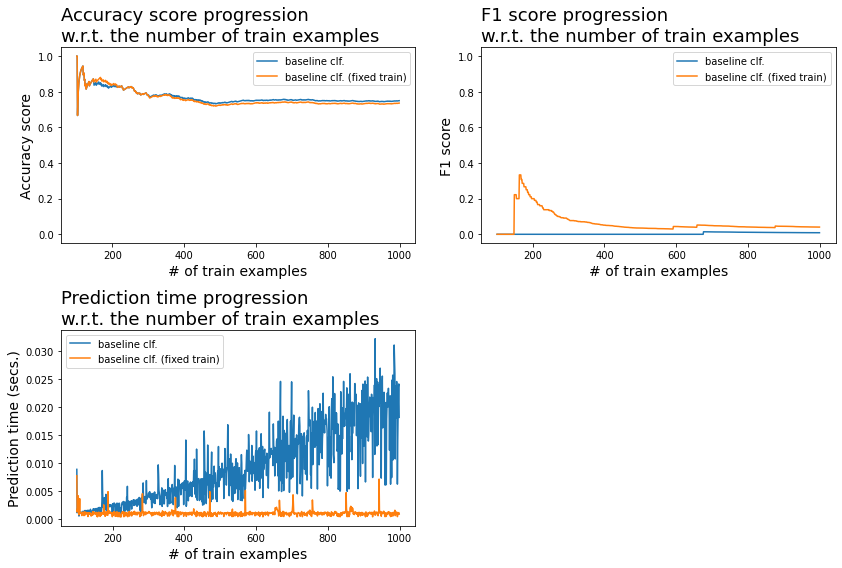

In [910]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = (1,1,1,1)  # Replace default "transparent" background of the figure with the "white" one


fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First two plots are for prediction quality comparison
for ax, t in zip(axs[0],['accuracy_score', 'f1_score']):
    ax.set_ylim(0-0.05, 1+0.05)
    ax.plot(range(n_train+1, len(X)), score_vals[t], label='baseline clf.')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_fixedtrain'], label='baseline clf. (fixed train)')
    
# The third plot is for prediction speed comparison
axs[1,0].plot(range(n_train, len(X)), t_preds, label='baseline clf.')
axs[1,0].plot(range(n_train, len(X)), t_preds_fixedtrain, label='baseline clf. (fixed train)')

# Add labels and titles to the plots
for (ax, t_verb, dim) in zip(axs.flatten(), ['Accuracy score', 'F1 score', 'Prediction time'], ['','','(secs.)']):
    ax.set_title('\n'.join([f"{t_verb} progression", "w.r.t. the number of train examples"]), loc='left', size=18)
    ax.set_xlabel('# of train examples', size=14)
    ax.set_ylabel(f"{t_verb} {dim}".strip(), size=14)
    ax.legend()
    
# Drop the predefined fourth plot since we do not use it
axs[1,1].set_axis_off()    

# Some postprocessing of plots
plt.tight_layout()
plt.subplots_adjust()

plt.savefig('Classifier_comparison.png')
plt.show()


# Numba + Own algorithm + Comparison DecTree, RandomForest

In [911]:
@nb.jit
def predict_with_generators(
        x: List[bool], X_train: List[set], Y_train: List[bool]
) -> bool:

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_pos = np.array(X_train)[np.array(Y_train)==1]
    X_neg = np.array(X_train)[np.array(Y_train)==0]

    n_same_pos = X_pos[np.where(np.all(X_pos == x, axis=1))].shape[0]
    n_same_neg = X_neg[np.where(np.all(X_neg == x, axis=1))].shape[0]

    if n_same_pos >= n_same_neg:
      return True
    
    else: return False

def predict_array(
        X: List[set], Y: List[bool],
        n_train: int, update_train: bool = True, use_tqdm: bool = False,
        predict_func: PREDICTION_FUNCTION_HINT = predict_with_generators,
        min_cardinality: int = 5
) -> Iterator[bool]:
    """Predict the labels of multiple examples from ``X``
    Parameters
    ----------
    X: List[set]
        Set of train and test examples to classify represented with subsets of attributes
    Y: List[bool]
        Set of train and test labels for each example from X
    n_train: int
        Initial number of train examples. That is, make predictions only for examples from X_train[n_train:]
    update_train: bool
        A flag whether to consider true labels of predicted examples as training data or not.
        If True, then for each X_i the training data consists of X_1, X_2, ..., X_{n_train}, ...,  X_{i-1}.
        If False, then for each X_i the training data consists of X_1, X_2, ..., X_{n_train}
    use_tqdm: bool
        A flag whether to use tqdm progress bar (in case you like progress bars)
    predict_func: <see PREDICTION_FUNCTION_HINT defined in this file>
        A function to make prediction for each specific example from ``X``.
        The default prediction function is ``predict_with_generator`` (considered as baseline for the home work).
    Returns
    -------
    prediction: Iterator
        Python generator with predictions for each x in X[n_train:]
    """
    for i, x in tqdm(
        enumerate(X[n_train:]),
        initial=n_train, total=len(X),
        desc='Predicting step by step',
        disable=not use_tqdm,
    ):
        n_trains = n_train + i if update_train else n_train
        yield predict_func(x, np.array(X[:n_trains]), np.array(Y[:n_trains]), min_cardinality = min_cardinality)


def apply_stopwatch(iterator: Iterator):
    """Measure run time of each iteration of ``iterator``
    The function can be applied e.g. for the output of ``predict_array`` function
    """
    outputs = []
    times = []

    t_start = time.time()
    for out in iterator:
        dt = time.time() - t_start
        outputs.append(out)
        times.append(dt)
        t_start = time.time()

    return outputs, times

In [922]:
%%time
gen = predict_array(np.array(X), np.array(y), n_train, use_tqdm=True, min_cardinality=3)
y_preds, t_preds = apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 1000/1000 [00:00<00:00, 7374.01it/s]

CPU times: user 133 ms, sys: 0 ns, total: 133 ms
Wall time: 133 ms


In [923]:
%%time
gen = predict_array(np.array(X), np.array(y), n_train, use_tqdm=True, update_train=False)
y_preds_fixedtrain, t_preds_fixedtrain = apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 1000/1000 [00:00<00:00, 15620.47it/s]

CPU times: user 58.8 ms, sys: 0 ns, total: 58.8 ms
Wall time: 62.5 ms


In [924]:
y_test = y[n_train:]

In [925]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       False       0.85      0.48      0.61       681
        True       0.31      0.73      0.44       219

    accuracy                           0.54       900
   macro avg       0.58      0.60      0.52       900
weighted avg       0.72      0.54      0.57       900



In [926]:
y_test = y[n_train:]

In [927]:
from sklearn.metrics import accuracy_score, f1_score

score_vals = {}
for score_f in [accuracy_score, f1_score]:
    score_name = score_f.__name__
    preds = y_preds
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    
    score_name = score_f.__name__ + '_fixedtrain'
    preds = y_preds_fixedtrain
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]

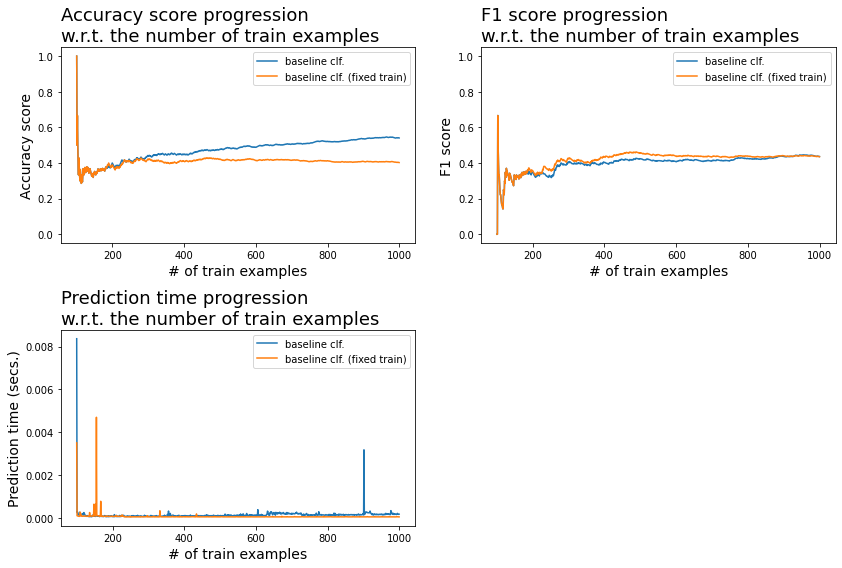

In [928]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = (1,1,1,1)  # Replace default "transparent" background of the figure with the "white" one


fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First two plots are for prediction quality comparison
for ax, t in zip(axs[0],['accuracy_score', 'f1_score']):
    ax.set_ylim(0-0.05, 1+0.05)
    ax.plot(range(n_train+1, len(X)), score_vals[t], label='baseline clf.')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_fixedtrain'], label='baseline clf. (fixed train)')
    
# The third plot is for prediction speed comparison
axs[1,0].plot(range(n_train, len(X)), t_preds, label='baseline clf.')
axs[1,0].plot(range(n_train, len(X)), t_preds_fixedtrain, label='baseline clf. (fixed train)')

# Add labels and titles to the plots
for (ax, t_verb, dim) in zip(axs.flatten(), ['Accuracy score', 'F1 score', 'Prediction time'], ['','','(secs.)']):
    ax.set_title('\n'.join([f"{t_verb} progression", "w.r.t. the number of train examples"]), loc='left', size=18)
    ax.set_xlabel('# of train examples', size=14)
    ax.set_ylabel(f"{t_verb} {dim}".strip(), size=14)
    ax.legend()
    
# Drop the predefined fourth plot since we do not use it
axs[1,1].set_axis_off()    

# Some postprocessing of plots
plt.tight_layout()
plt.subplots_adjust()

plt.savefig('Classifier_comparison.png')
plt.show()


In [919]:
%%time

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.15)

tree = DecisionTreeClassifier().fit(X_train, y_train)

preds = tree.predict(X_test).tolist()

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       False       0.77      0.88      0.82       108
        True       0.50      0.31      0.38        42

    accuracy                           0.72       150
   macro avg       0.63      0.59      0.60       150
weighted avg       0.69      0.72      0.70       150

CPU times: user 12.7 ms, sys: 984 µs, total: 13.7 ms
Wall time: 14.9 ms


In [920]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.15)

rf = RandomForestClassifier().fit(X_train, y_train)

preds = rf.predict(X_test).tolist()

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       False       0.78      0.87      0.82       110
        True       0.48      0.33      0.39        40

    accuracy                           0.73       150
   macro avg       0.63      0.60      0.61       150
weighted avg       0.70      0.73      0.71       150

CPU times: user 178 ms, sys: 3.01 ms, total: 181 ms
Wall time: 182 ms


# Pattern structure

In [779]:

def predict_with_generators_pattern(
        x: List[bool], X_train: List[set], Y_train: List[bool]
) -> bool:

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_pos = np.array(X_train)[np.array(Y_train)==1]
    X_neg = np.array(X_train)[np.array(Y_train)==0]
    


    for row in range(X_train.shape[0]):
      pos = 0
      neg = 0
      conds = [(min(k, l), max(k, l)) for k,l in zip(X_train[row], x)]
      for rowc in range(row+1,X_train.shape[0]):
        
        for col in range(X_train.shape[1]):
          #------
          if type(X_train[rowc][col]) in [np.float64, int, float]:
            if (X_train[rowc][col] >= conds[col][0]) and (X_train[rowc][col] <= conds[col][1]):
              pass
            else:
              break
          #-------
          elif type(X_train[rowc][col]) not in [np.float64, int, float]:
            if (X_train[rowc][col] in conds[col]):
              pass
            else:
              break
          #--------
        else:
          if y[rowc] == True:
            pos += 1
          else: neg += 1
        
      if pos > 0 and neg == 0:
        #print("POS", pos)
        return True
      elif pos == 0 and neg > 0:
        #print("NEG", neg)
        return False
      #print(row)
    return "UNCLASS"
    



def predict_array_pattern(
        X: List[set], Y: List[bool],
        n_test: int, use_tqdm: bool = False,
        predict_func: PREDICTION_FUNCTION_HINT = predict_with_generators_pattern,
        min_cardinality: int = 5
) -> Iterator[bool]:
    """Predict the labels of multiple examples from ``X``
    Parameters
    ----------
    X: List[set]
        Set of train and test examples to classify represented with subsets of attributes
    Y: List[bool]
        Set of train and test labels for each example from X
    n_train: int
        Initial number of train examples. That is, make predictions only for examples from X_train[n_train:]
    update_train: bool
        A flag whether to consider true labels of predicted examples as training data or not.
        If True, then for each X_i the training data consists of X_1, X_2, ..., X_{n_train}, ...,  X_{i-1}.
        If False, then for each X_i the training data consists of X_1, X_2, ..., X_{n_train}
    use_tqdm: bool
        A flag whether to use tqdm progress bar (in case you like progress bars)
    predict_func: <see PREDICTION_FUNCTION_HINT defined in this file>
        A function to make prediction for each specific example from ``X``.
        The default prediction function is ``predict_with_generator`` (considered as baseline for the home work).
    Returns
    -------
    prediction: Iterator
        Python generator with predictions for each x in X[n_train:]
    """
    for i, x in tqdm(
        enumerate(X[:n_test]),
        initial=0, total=n_test,
        desc='Predicting step by step',
        disable=not use_tqdm,
    ):
        yield predict_func(x, np.array(X[n_test:]), np.array(Y[n_test:]))


def apply_stopwatch(iterator: Iterator):
    """Measure run time of each iteration of ``iterator``
    The function can be applied e.g. for the output of ``predict_array`` function
    """
    outputs = []
    times = []

    t_start = time.time()
    for out in iterator:
        dt = time.time() - t_start
        outputs.append(out)
        times.append(dt)
        t_start = time.time()

    return outputs, times

In [837]:
df = pd.read_csv('/content/healthcare-dataset-stroke-data (1).csv')



df = df[:2000]

df = df.sample(frac=1).reset_index(drop=True)

df['bmi'].fillna(df['bmi'].mean(), inplace=True)

y = df['stroke']
X = df.drop(columns='stroke')

n_test = 200

In [788]:
%%time
gen = predict_array_pattern(np.array(X), np.array(y), n_test, use_tqdm=True)
y_preds, t_preds = apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 200/200 [00:02<00:00, 78.54it/s]

CPU times: user 2.53 s, sys: 14 ms, total: 2.54 s
Wall time: 2.55 s


In [789]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
print(classification_report(y[:n_test], y_preds))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       178
           1       0.20      0.05      0.07        22

    accuracy                           0.88       200
   macro avg       0.55      0.51      0.50       200
weighted avg       0.82      0.88      0.84       200



In [791]:
X = pd.get_dummies(data=X, columns=obj_cols)

In [792]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.15)

tree = DecisionTreeClassifier().fit(X_train, y_train)

preds = tree.predict(X_test).tolist()

print(classification_report(y_test, preds))


              precision    recall  f1-score   support

           0       0.91      0.84      0.88       269
           1       0.18      0.29      0.22        31

    accuracy                           0.79       300
   macro avg       0.54      0.57      0.55       300
weighted avg       0.84      0.79      0.81       300

CPU times: user 28 ms, sys: 984 µs, total: 29 ms
Wall time: 50.7 ms


In [793]:

%%time

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.15)

rf = RandomForestClassifier().fit(X_train, y_train)

preds = rf.predict(X_test).tolist()

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       265
           1       0.50      0.06      0.10        35

    accuracy                           0.88       300
   macro avg       0.69      0.52      0.52       300
weighted avg       0.84      0.88      0.84       300

CPU times: user 289 ms, sys: 994 µs, total: 290 ms
Wall time: 292 ms


In [835]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 20 kB/s 


In [841]:
import catboost as cat

y = df['stroke']
X = df.drop(columns='stroke')

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.15)

rf = cat.CatBoostClassifier().fit(X_train, y_train, cat_features=obj_cols)

preds = rf.predict(X_test).tolist()

print(classification_report(y_test, preds))

Learning rate set to 0.012922
0:	learn: 0.6778996	total: 4.79ms	remaining: 4.78s
1:	learn: 0.6625244	total: 10.1ms	remaining: 5.03s
2:	learn: 0.6506865	total: 14.7ms	remaining: 4.89s
3:	learn: 0.6371107	total: 19.4ms	remaining: 4.83s
4:	learn: 0.6277790	total: 22.9ms	remaining: 4.56s
5:	learn: 0.6157357	total: 27.5ms	remaining: 4.55s
6:	learn: 0.6056440	total: 32.1ms	remaining: 4.55s
7:	learn: 0.5942845	total: 36.8ms	remaining: 4.56s
8:	learn: 0.5840342	total: 39.2ms	remaining: 4.32s
9:	learn: 0.5741785	total: 43.9ms	remaining: 4.34s
10:	learn: 0.5646494	total: 46.6ms	remaining: 4.19s
11:	learn: 0.5544565	total: 51.2ms	remaining: 4.22s
12:	learn: 0.5436618	total: 56ms	remaining: 4.25s
13:	learn: 0.5353901	total: 60ms	remaining: 4.22s
14:	learn: 0.5265279	total: 63.8ms	remaining: 4.19s
15:	learn: 0.5178029	total: 66.6ms	remaining: 4.1s
16:	learn: 0.5100330	total: 69.5ms	remaining: 4.02s
17:	learn: 0.5049644	total: 72.8ms	remaining: 3.97s
18:	learn: 0.5003914	total: 74.7ms	remaining: 3.8

# Comparison

## DS 1

In [794]:
df_1 = pd.read_csv('/content/citrus.csv')

df_1 = df_1.sample(frac=1).reset_index(drop=True)[:2000]

In [795]:
numeric = ['diameter', 'weight', 'red', 'green', 'blue']
target = 'name'

In [796]:
df_1['target'] = pd.get_dummies(df_1[target])['orange']
df_1.drop(columns='name', inplace=True)

In [798]:
y = df_1['target']
X = df_1.drop(columns='target')

In [805]:
%%time

n_test = 300
gen = predict_array_pattern(np.array(X), np.array(y), n_test, use_tqdm=True)
y_preds, t_preds = apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 300/300 [00:15<00:00, 19.46it/s]

CPU times: user 13.3 s, sys: 75.6 ms, total: 13.4 s
Wall time: 15.4 s


In [806]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
print(classification_report(y[:n_test], y_preds))

              precision    recall  f1-score   support

           0       0.48      0.54      0.51       147
           1       0.49      0.42      0.46       153

    accuracy                           0.48       300
   macro avg       0.48      0.48      0.48       300
weighted avg       0.48      0.48      0.48       300



## DS 2

In [819]:
df_2 = pd.read_csv('/content/diabetes 2.csv')

df_2 = df_2.sample(frac=1).reset_index(drop=True)

In [820]:
y = df_2['Outcome']
X = df_2.drop(columns='Outcome')

In [821]:
%%time

n_test = 150
gen = predict_array_pattern(np.array(X), np.array(y), n_test, use_tqdm=True)
y_preds, t_preds = apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 150/150 [00:01<00:00, 108.31it/s]

CPU times: user 1.36 s, sys: 7.99 ms, total: 1.37 s
Wall time: 1.39 s


In [822]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
print(classification_report(y[:n_test], y_preds))

              precision    recall  f1-score   support

           0       0.67      0.65      0.66       101
           1       0.31      0.33      0.32        49

    accuracy                           0.55       150
   macro avg       0.49      0.49      0.49       150
weighted avg       0.55      0.55      0.55       150



## DS 3

In [827]:
df_3 = pd.read_csv('/content/data (1).csv')

df_3 = df_3.sample(frac=1).reset_index(drop=True)

df_3.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,56,1,4,120,85,0,0,140,0,0.0,?,?,?,0
1,49,1,4,140,234,0,0,140,1,1.0,2,?,?,1
2,54,1,4,200,198,0,0,142,1,2.0,2,?,?,1
3,44,1,4,150,412,0,0,170,0,0.0,?,?,?,0
4,57,1,4,150,255,0,0,92,1,3.0,2,?,?,1


In [828]:
df_3.drop(columns=['slope', 'ca', 'thal'], inplace=True)

In [831]:
y = df_3['num       ']
X = df_3.drop(columns='num       ')

In [832]:
%%time

n_test = 50
gen = predict_array_pattern(np.array(X), np.array(y), n_test, use_tqdm=True)
y_preds, t_preds = apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 50/50 [00:01<00:00, 27.34it/s]

CPU times: user 1.59 s, sys: 9.89 ms, total: 1.6 s
Wall time: 1.85 s


In [833]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
print(classification_report(y[:n_test], y_preds))

              precision    recall  f1-score   support

           0       0.56      0.89      0.68        28
           1       0.40      0.09      0.15        22

    accuracy                           0.54        50
   macro avg       0.48      0.49      0.42        50
weighted avg       0.49      0.54      0.45        50



## Lets check My Lazy FCA algorithm on one of datasets

In [843]:
df_1 = pd.read_csv('/content/citrus.csv')

df_1 = df_1.sample(frac=1).reset_index(drop=True)[:2000]

In [844]:
numeric = ['diameter', 'weight', 'red', 'green', 'blue']
target = 'name'

In [845]:
df_1 = binarize_numerical(df_1, numeric)

In [846]:
df_1['target'] = pd.get_dummies(df_1[target])['orange']
df_1.drop(columns='name', inplace=True)

In [854]:
%%time
y = df_1['target']
X = df_1.drop(columns='target')

n_train = 200
gen = predict_array(np.array(X), np.array(y), n_train, use_tqdm=True)
y_preds, t_preds = apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 2000/2000 [00:01<00:00, 1761.91it/s]

CPU times: user 979 ms, sys: 29.1 ms, total: 1.01 s
Wall time: 1.05 s


In [855]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
print(classification_report(y[n_train:], y_preds))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89       902
           1       0.88      0.89      0.89       898

    accuracy                           0.89      1800
   macro avg       0.89      0.89      0.89      1800
weighted avg       0.89      0.89      0.89      1800



Now without using pattern structure we got 90% accuracy and 90% mean F1 score